In [1]:
import numpy as np
import pandas as pd
import altair as A
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import sklearn.manifold as manifold
pd.options.mode.chained_assignment = None

In [2]:
df_battles = pd.read_csv('battles.csv')
df_deaths = pd.read_csv('character-deaths.csv')
df_predictions = pd.read_csv('character-predictions.csv')

Visualising Game of thrones deaths
=====

For information about the dataset, it is downloaded from here: https://www.kaggle.com/mylesoneill/game-of-thrones
Where you can find a full description of what it contains.

So as a part of the challenge from [Siraj Raval](https://www.youtube.com/watch?v=yQsOFWqpjkE) he mentioned using T-SNE to visualize a dataset.

T-SNE being a fairly new algorithm to reduce a high dimensionality dataset to a lower one. I have never used it before so I wanted to see what it was all about.

First we need to have some understanding of what T-SNE does, some good links are [How to User t-SNE effectively](http://distill.pub/2016/misread-tsne/) and [Visualizing with t-SNE](https://indico.io/blog/visualizing-with-t-sne/).

So snuggle up with a kitten, grab a coffe and onwards to the data

![alt text](http://i2.kym-cdn.com/photos/images/original/000/002/258/1143362243714.jpg "Grab a kitten")

In [42]:
print("We have a total of {} characters and {} deaths".format(len(df_deaths), len(df_deaths.dropna())))

We have a total of 917 characters and 292 deaths


## Cleaning up the dataset

Our first naive approach is to just visualize all our deaths. Lets clean it up by removing all people that have not died then label encode our allegiances.

In [17]:
tsne = manifold.TSNE()
# Living people are represented with lots of nan
clean_data = df_deaths.dropna()
# We make our allegiances easier to read. Remove the word house from the start
clean_data["Allegiances"] = clean_data["Allegiances"].apply(lambda x: x[6:] if x.startswith("House ") else x)
le_allegiances = sklearn.preprocessing.LabelEncoder()
clean_data["encoded_allegiances"] = le_allegiances.fit_transform(clean_data["Allegiances"])

# All rows but not column Name and Allegiances
transformed_data = tsne.fit_transform(clean_data.ix[:,2:])
clean_data["lowered_x"] = transformed_data[:,0]
clean_data["lowered_y"] = transformed_data[:,1]

And plot... matplotlib is very down to earth but lets look to the stars with vega and [altair](https://github.com/altair-viz/altair)

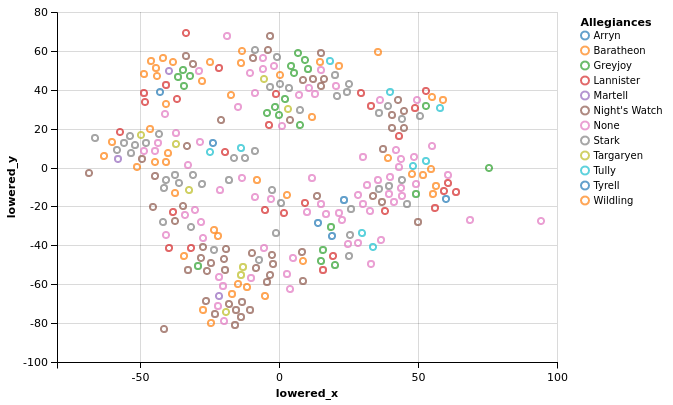

In [5]:
A.Chart(clean_data).mark_point().encode(
    x="lowered_x",
    y="lowered_y",
    color="Allegiances")

Does not look like anything to me

![alt text](https://4d0850cecf2c5ce919d5-17b283ac00835b5ced4db83c898330a1.ssl.cf1.rackcdn.com/12217173_westworlds-badass-lady-gunslinger-is_t7ab0986a.gif "Westworld")

Time to debug... Things that might be interesting to tweak are:
* Iterations: Ff we can up the number of iterations run we can be sure to have a at least as good as a result
* Perplexity: Can yield different result, altough the description says it is fairly resilient to changes
* Method: Right now we are running the approximation method we could try exact 
* Learning rate: It is set to 1000 per default, but never hurts to try a few different onces.

In [6]:
tsne = manifold.TSNE(verbose=2)
transformed_data = tsne.fit_transform(clean_data.ix[:,2:])
clean_data["lowered_x"] = transformed_data[:,0]
clean_data["lowered_y"] = transformed_data[:,1]

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 292 / 292
[t-SNE] Mean sigma: 8.516435
[t-SNE] Iteration 25: error = 0.5827339, gradient norm = 0.0207586
[t-SNE] Iteration 50: error = 0.6803517, gradient norm = 0.0203473
[t-SNE] Iteration 75: error = 0.6939481, gradient norm = 0.0194921
[t-SNE] Iteration 100: error = 1.8491197, gradient norm = 0.0309009
[t-SNE] Error after 100 iterations with early exaggeration: 1.849120
[t-SNE] Iteration 125: error = 1.9261400, gradient norm = 0.0284691
[t-SNE] Iteration 150: error = 2.2558751, gradient norm = 0.0215662
[t-SNE] Iteration 175: error = 2.1490777, gradient norm = 0.0024431
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 2.149078


Call me old fashioned but i like my error rates going down, so unless we are really stuck in a local optima since this algorithm is running gradient descent, I think we should try lowering learning_rate

In [18]:
tsne = manifold.TSNE(verbose=2, learning_rate=400)
transformed_data = tsne.fit_transform(clean_data.ix[:,2:])
clean_data["lowered_x"] = transformed_data[:,0]
clean_data["lowered_y"] = transformed_data[:,1]

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 292 / 292
[t-SNE] Mean sigma: 18.092203
[t-SNE] Iteration 25: error = 0.4442641, gradient norm = 0.0061057
[t-SNE] Iteration 50: error = 0.4016587, gradient norm = 0.0092287
[t-SNE] Iteration 75: error = 0.3126081, gradient norm = 0.0036897
[t-SNE] Iteration 100: error = 0.2996741, gradient norm = 0.0044430
[t-SNE] Error after 100 iterations with early exaggeration: 0.299674
[t-SNE] Iteration 125: error = 0.2848360, gradient norm = 0.0024615
[t-SNE] Iteration 150: error = 0.2897037, gradient norm = 0.0036946
[t-SNE] Iteration 175: error = 0.2813554, gradient norm = 0.0039410
[t-SNE] Iteration 200: error = 0.2793917, gradient norm = 0.0030778
[t-SNE] Iteration 225: error = 0.2920574, gradient norm = 0.0059651
[t-SNE] Iteration 250: error = 0.3102852, gradient norm = 0.0088959
[t-SNE] Iteration 250: did not make any progress during the last 30 episodes. 

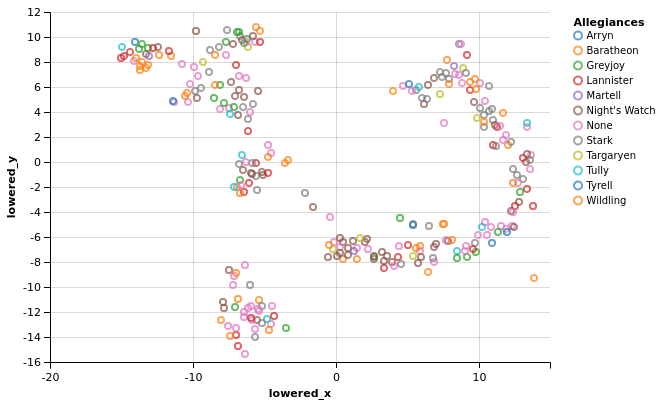

In [19]:
A.Chart(clean_data).mark_point().encode(
    x="lowered_x",
    y="lowered_y",
    color="Allegiances")

Looks like we got something at least 2 clusters, okay we will fiddle a little more with the parameters and see if we can find something better. 

In [30]:
tsne_exact = manifold.TSNE(method="exact", n_iter=5000, learning_rate=400, perplexity=40, verbose=2, n_iter_without_progress=3000)

In [31]:
transformed_data = tsne_exact.fit_transform(clean_data.ix[:,2:])
clean_data["lowered_x"] = transformed_data[:,0]
clean_data["lowered_y"] = transformed_data[:,1]

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 292 / 292
[t-SNE] Mean sigma: 10.896010
[t-SNE] Iteration 25: error = 10.7301796, gradient norm = 0.1421587
[t-SNE] Iteration 50: error = 11.3211714, gradient norm = 0.1122675
[t-SNE] Iteration 75: error = 10.3952173, gradient norm = 0.1283859
[t-SNE] Iteration 100: error = 10.8023996, gradient norm = 0.1177620
[t-SNE] Error after 100 iterations with early exaggeration: 10.802400
[t-SNE] Iteration 125: error = 0.1700905, gradient norm = 0.0052615
[t-SNE] Iteration 150: error = 0.1462693, gradient norm = 0.0004747
[t-SNE] Iteration 175: error = 0.1452886, gradient norm = 0.0001741
[t-SNE] Iteration 200: error = 0.1450585, gradient norm = 0.0001647
[t-SNE] Iteration 225: error = 0.1449986, gradient norm = 0.0001628
[t-SNE] Iteration 250: error = 0.1449822, gradient norm = 0.0001623
[t-SNE] Iteration 275: error = 0.1449777, gradient norm = 0.0001621
[t-SNE] Iteration 300: error = 0.1449765, gradi

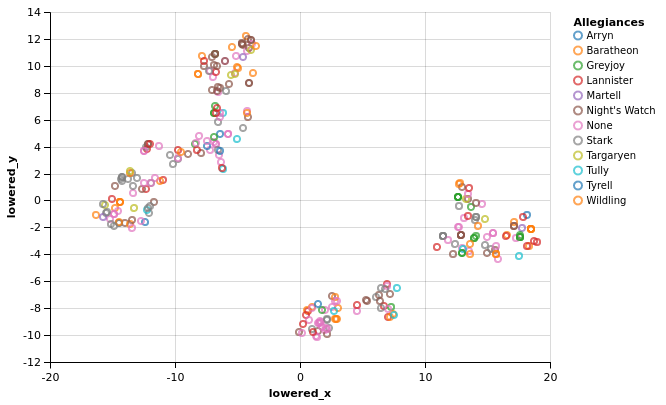

In [32]:
A.Chart(clean_data).mark_point().encode(
    x="lowered_x",
    y="lowered_y",
    color="Allegiances")

![alt text](http://media.timeout.com/blogimages/wp-content/uploads/2014/04/margaery-tyrell-game-of-thrones-pity.gif "I never trust data where I have to squint to see the regression") Success, but for the fun of it lets compare with different perplexities. Before we try to find out what we found.

In [23]:
def generate_projection(data, perplexity):
    tsne_exact = manifold.TSNE(method="exact", n_iter=5000, learning_rate=400, perplexity=perplexity, verbose=1, n_iter_without_progress=3000)
    transformed_data = tsne_exact.fit_transform(data.ix[:,2:])
    data = pd.DataFrame(transformed_data, columns=["lowered_x", "lowered_y"])
    data["Perplexity"] = perplexity
    return data

data = pd.concat([generate_projection(clean_data, perplexity) for perplexity in [2,5,30,50,100]])

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 292 / 292
[t-SNE] Mean sigma: 0.047540
[t-SNE] Error after 100 iterations with early exaggeration: 19.586832
[t-SNE] Error after 225 iterations: 2.072541
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 292 / 292
[t-SNE] Mean sigma: 2.374424
[t-SNE] Error after 100 iterations with early exaggeration: 14.308058
[t-SNE] Error after 225 iterations: 1.058832
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 292 / 292
[t-SNE] Mean sigma: 8.891778
[t-SNE] Error after 100 iterations with early exaggeration: 11.517378
[t-SNE] Error after 225 iterations: 0.212067
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 292 / 292
[t-SNE] Mean sigma: 12.655082
[t-SNE] Error after 100 iterations with early exaggeration: 10.363481
[t-SNE] Error after 725 iterations: 0.128762
[t-SNE]

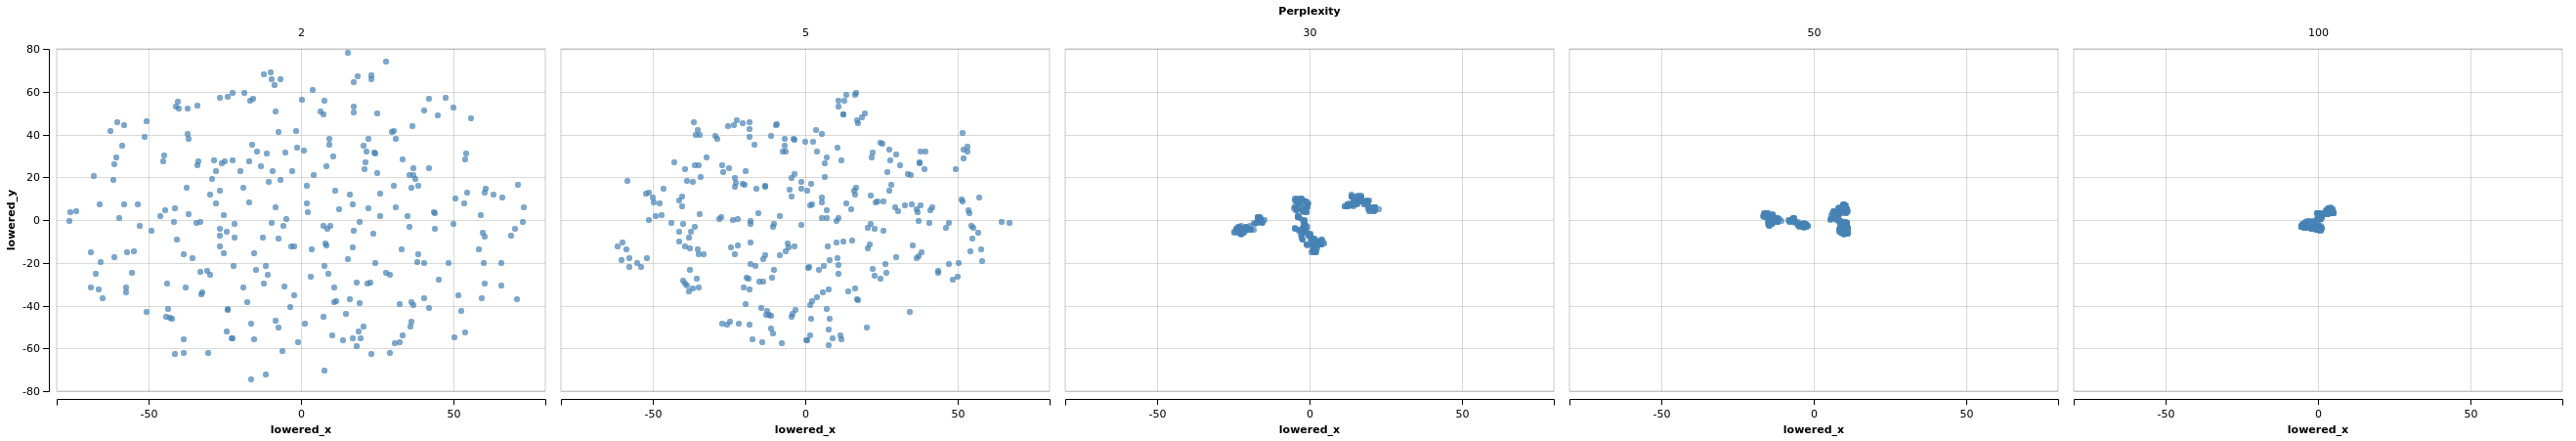

In [24]:
A.Chart(data).mark_circle().encode(
    x="lowered_x",
    y="lowered_y",
    column="Perplexity")

I must say t-sne does seem like a fickle tool. So hard to tell but somewhere between 30 and 50 all seem to converge to a similar shape and groupings.

Anyways back to the division.First off how egalitarian is dear Mr.Martin towards gender and peasants?
![alt text](http://andrewmanugian.files.wordpress.com/2012/06/george-rr-martin.jpg "George RR Martin looks like marx")

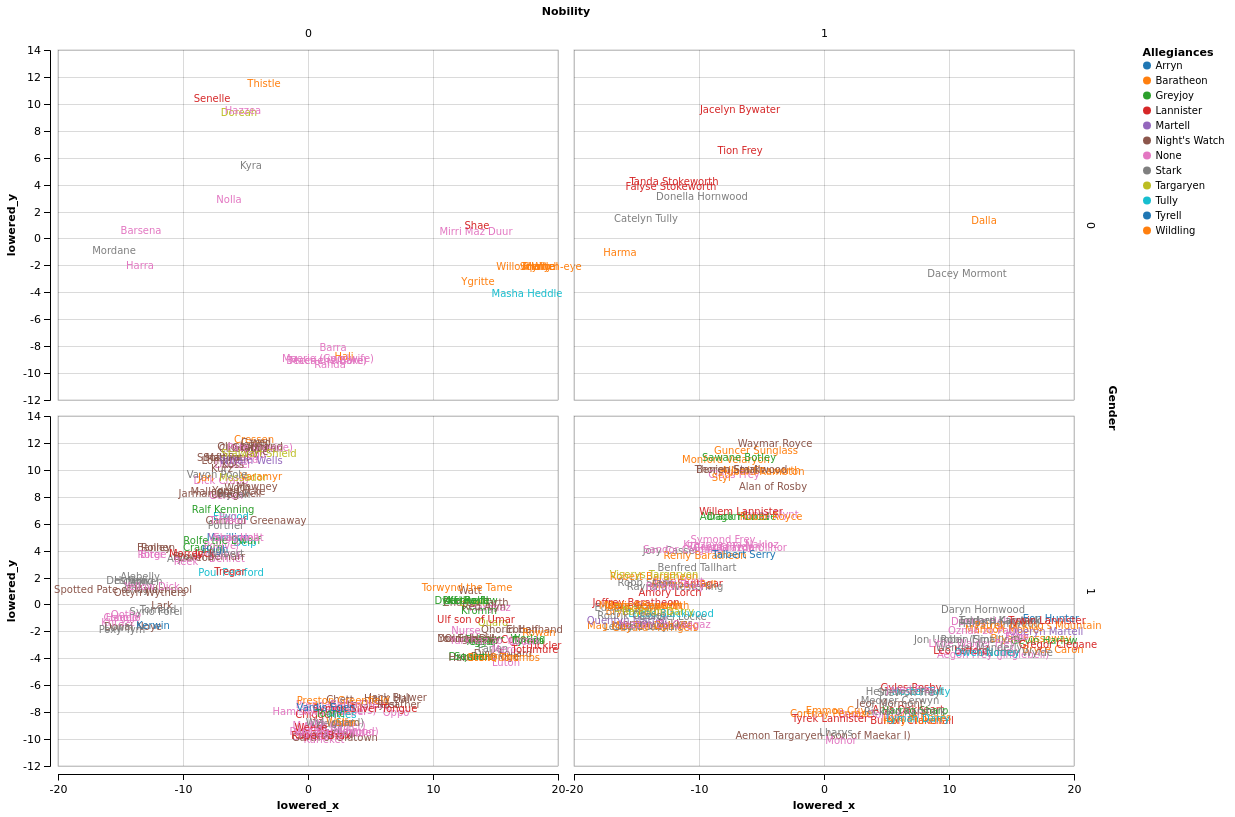

In [33]:
A.Chart(clean_data).mark_text().encode(
    x="lowered_x",
    y="lowered_y",
    row="Gender",
    column="Nobility",
    text="Name",
    color="Allegiances")

Nothing at all in regards to shape. Although I must say he does kill a lot more males.

Now I did run the t-sne quite a few times and it is nowhere near stable, if it is because of how I use the tool or not I don't know. But I did find one interesting seperation. The data seems to have a gap that is present each run. And that is which chapter people die at,for example if we split it in half, we can see it seperated it into two different clusters. I tried doing a higher number but did not find anything. But more than that I cant draw any real conclusions.

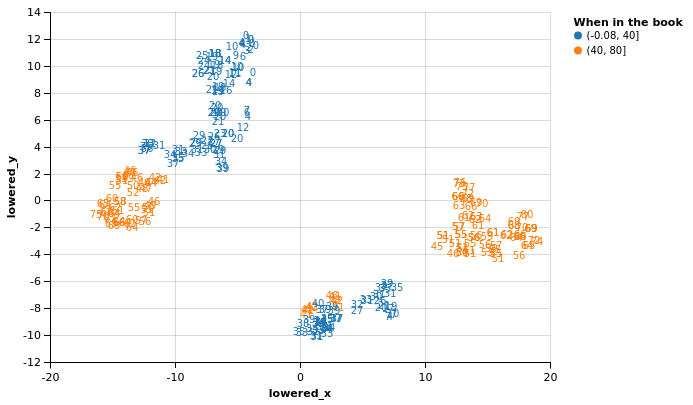

In [41]:
clean_data["When in the book"] = pd.cut(clean_data["Death Chapter"], 2)
A.Chart(clean_data).mark_text(format="c").encode(
    x="lowered_x",
    y="lowered_y",
    text=A.Text("Death Chapter"),
    color="When in the book")

In the end a fun practice session using this tool, thanks Siraj!